In [1]:
%matplotlib inline
import numpy as np
import os
from datavyz import graph_env_dark_notebook as ge

In [2]:
# LOCs = np.load('data/nmda-spike/locations.npy')
LOCs = [74, 124, 313, 363, 474, 630, 680, 800, 886, 936, 1036, 1227, 1428, 1478, 1634, 1856, 2117, 2183, 2233, 2379, 2429, 3177, 3319, 3464, 3514]

In [3]:
from single_cell_sim import *
from model import Model

def run_sim(Model,
            syn_packets=[{'loc':0, 'nsyn':5, 'label':'1'},
                         {'loc':1, 'nsyn':5, 'label':'2'}],
            activation_sequence=[{'time':200,
                                  'packet':0},
                                 {'time':400,
                                  'packet':1}],
          syn_packet_width=5,
            Nsyn_per_loc=25,
            post_duration=200.,
            active=False,
            stim_seed=0,
            ampa_only=False,
            chelated=False):


    Modelc = Model.copy()
    tstop = activation_sequence[-1]['time']+post_duration
    if chelated:
        Modelc['alphaZn'] = 0.

    t, neuron, SEGMENTS = initialize_sim(Model,
                                         active=active,
                                         tstop=tstop)

    np.random.seed(stim_seed)
    
    PACKETS, ulocs = [], np.unique([sp['loc'] for sp in syn_packets])
    for i, sp in enumerate(syn_packets):
        i0 = np.argwhere(sp['loc']==ulocs).flatten()[0] # to catch syn packets at the same location
        locs = LOCs[sp['loc']]+np.arange(Nsyn_per_loc)
        times = np.sort(np.random.randn(sp['nsyn'])*syn_packet_width)
        IDs = np.random.choice(i0*Nsyn_per_loc+np.arange(Nsyn_per_loc), sp['nsyn'], replace=False)
        labels = [sp['label'] for i in range(sp['nsyn'])]
        PACKETS.append({'times':times, 'IDs':IDs, 'locs':locs, 'labels':labels})
        
    syn_IDs, syn_times, syn_labels = np.empty(0, dtype=int), np.empty(0, dtype=float), np.empty(0, dtype=str)

    for i, act in enumerate(activation_sequence):
        syn_times = np.concatenate([syn_times,
                                    act['time']+PACKETS[act['packet']]['times']])
        syn_IDs = np.concatenate([syn_IDs,
                                  PACKETS[act['packet']]['IDs']])
        syn_labels = np.concatenate([syn_labels, PACKETS[act['packet']]['labels']])

    if ampa_only:
        Modelc['qNMDA'] = 0.
    elif chelated:
        Modelc['Deltax0'] = 0.
        
    Estim, ES = ntwk.process_and_connect_event_stimulation(neuron,
                                                           syn_IDs, syn_times,
                                                           np.concatenate([(LOCs[ul]+np.arange(Nsyn_per_loc)) for ul in ulocs]),
                                                           EXC_SYNAPSES_EQUATIONS.format(**Modelc),
                                                           ON_EXC_EVENT.format(**Modelc))

    # recording and running
    M = ntwk.StateMonitor(neuron, ('v'), record=[0]+[sp['loc'] for sp in syn_packets])
    S = ntwk.StateMonitor(ES, ('X', 'gAMPA', 'gRiseNMDA', 'gDecayNMDA', 'bZn'), record=[0])

    # # Run simulation
    ntwk.run(tstop*ntwk.ms)
    
    data = {'t':np.array(M.t/ntwk.ms), 
            'Vm_soma':np.array(M.v/ntwk.mV)[0,:],
            'bZn_syn':np.array(S.bZn)[0,:],
            'gAMPA_syn':np.array(S.gAMPA/ntwk.nS)[0,:],
            'X_syn':np.array(S.X)[0,:],
            'Vm_syn':np.array(M.v/ntwk.mV)[1,:],
            'syn_times': syn_times,
            'syn_IDs': syn_IDs,
            'syn_labels': syn_labels,
            'Model':Modelc}
    data['gNMDA_syn']= Model['qNMDA']*Model['nNMDA']*\
        (np.array(S.gDecayNMDA)[0,:]-np.array(S.gRiseNMDA)[0,:])\
        /(1+Model['etaMg']*Model['cMg']*np.exp(-data['Vm_syn']/Model['V0NMDA']))\
        *(1-Model['alphaZn']*data['bZn_syn'])
    
    return data




In [4]:
# for activation_sequence in [[{'time':50, 'packet':2}],
#                             [{'time':50, 'packet':3}],
#                             [{'time':50, 'packet':2}, {'time':100, 'packet':3}],
#                             [{'time':50, 'packet':2}, {'time':100, 'packet':2}],
#                             [{'time':50, 'packet':3}, {'time':100, 'packet':3}],
#                             [{'time':50, 'packet':0}],
#                             [{'time':50, 'packet':1}],
#                             [{'time':50, 'packet':0}, {'time':200, 'packet':1}],
#                             [{'time':50, 'packet':1}, {'time':200, 'packet':1}],
#                             [{'time':50, 'packet':0}, {'time':200, 'packet':0}]]:


In [5]:
def build_fig(list_data_freeZn, list_data_chelatedZn,
              space=50, Tbar=20):
    # fig shape
    fig, AX = ge.figure(axes_extents=[[[1,2]],
                                      [[3,5]]], figsize=(3.,.3), hspace=0)

    t0=0
    for data_freeZn, data_chelatedZn in zip(list_data_freeZn, list_data_chelatedZn):
        for label, color in zip(['1', '2', '3', '4'], [ge.cyan, ge.pink, ge.purple, ge.orange]):
            cond = (data_freeZn['syn_labels']==label)
            AX[0].plot(t0+data_freeZn['syn_times'][cond], data_freeZn['syn_IDs'][cond], 'o', ms=2, color=color)

        AX[1].plot(t0+data_chelatedZn['t'], data_chelatedZn['Vm_soma'], color=ge.green, lw=2)
        AX[1].plot(t0+data_freeZn['t'], data_freeZn['Vm_soma'], color='k', lw=1)
        t0 += data_chelatedZn['t'][-1]+space
        
    ge.set_plot(AX[0], [], xlim=[0, t0], ylim=[-2, AX[0].get_ylim()[1]+2])
    ge.set_plot(AX[1], [], xlim=[0, t0])
    ge.draw_bar_scales(AX[0], Xbar=Tbar, Xbar_label='%ims' % Tbar, Ybar=10, Ybar_label='10 syn.', xyLoc=(0,AX[0].get_ylim()[1]))
    ge.draw_bar_scales(AX[1], Xbar=1e-10, Xbar_label='', Ybar=10, Ybar_label='10mV ', xyLoc=(0,-50))
    ge.annotate(AX[1], '\n  free Zinc', (0,.9), va='top')
    ge.annotate(AX[1], '  chelated Zinc', (0,.9), va='top', color=ge.green)
    ge.annotate(AX[1], '-75mV  -> ', (0,-75), va='center', ha='right', xycoords='data')
 

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


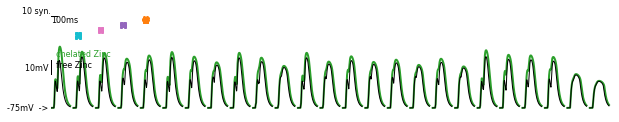

In [7]:
list_data_freeZn, list_data_chelatedZn = [], []


syn_packets=[{'loc':i, 'nsyn':15, 'label':str(i)} for i in range(len(LOCs))]

for activation_sequence in [[{'time':50, 'packet':i}, {'time':100, 'packet':i}] for i in range(len(LOCs))]:
    
    data_chelatedZn = run_sim(Model, syn_packets=syn_packets, activation_sequence=activation_sequence,
                              chelated=True)

    data_freeZn = run_sim(Model, syn_packets=syn_packets, activation_sequence=activation_sequence,
                          chelated=False)
    list_data_freeZn.append(data_freeZn)
    list_data_chelatedZn.append(data_chelatedZn)
    
build_fig(list_data_freeZn, list_data_chelatedZn, Tbar=100)


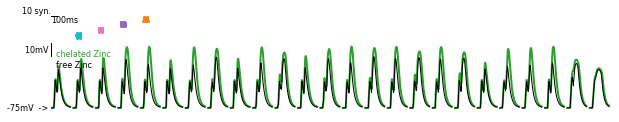

In [8]:
list_data_freeZn, list_data_chelatedZn = [], []


syn_packets=[{'loc':i, 'nsyn':10, 'label':str(i)} for i in range(len(LOCs))]

for activation_sequence in [[{'time':50, 'packet':i}, {'time':100, 'packet':i}] for i in range(len(LOCs))]:
    
    data_chelatedZn = run_sim(Model, syn_packets=syn_packets, activation_sequence=activation_sequence,
                              chelated=True)

    data_freeZn = run_sim(Model, syn_packets=syn_packets, activation_sequence=activation_sequence,
                          chelated=False)
    list_data_freeZn.append(data_freeZn)
    list_data_chelatedZn.append(data_chelatedZn)
    
build_fig(list_data_freeZn, list_data_chelatedZn, Tbar=100)

In [17]:
from scipy.stats import ttest_rel, wilcoxon

2.88 1.0703270528207722
3.96 1.215894732285653
WilcoxonResult(statistic=0.0, pvalue=5.960464477539063e-08)


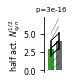

In [23]:
from datavyz import ge

first_observations = np.array(FWHM['chelatedZn'])-3
second_observations = np.array(FWHM['freeZn'])-3
color1=ge.green
color2='dimgrey'
lw=0.3
ylabel='half act. $N_{syn}^{1/2}$'
fig_args={'figsize':(.5,1.2)}
xticks_rotation=70

pval = ttest_rel(first_observations, second_observations)[1]
fig4, ax = ge.figure(**fig_args)
    
for i in range(len(first_observations)):
    ax.plot([0, 1], [first_observations[i], second_observations[i]], '-', lw=lw, color='k')
    
ax.bar([0], [np.mean(first_observations)], yerr=np.std(first_observations), color=color1, lw=lw)
ax.bar([1], [np.mean(second_observations)], yerr=np.std(second_observations), color=color2, lw=lw)

print(np.mean(first_observations), np.std(first_observations))
print(np.mean(second_observations), np.std(second_observations))
print(wilcoxon(first_observations, second_observations))

ge.title(ax, 'p=%.0e   ' % pval, size='small')

ge.set_plot(ax, ['left'],
            #yticks=[0, 3, 6], yticks_labels = ['3', '6', '9'],
            ylim = [-.2, 7.2],
            ylabel=ylabel)

1.43984 0.28611629523674464
0.92604 0.17616639407106
WilcoxonResult(statistic=0.0, pvalue=5.960464477539063e-08)


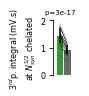

In [22]:
from datavyz import ge

first_observations = np.array(HML['chelatedZn'])/1e3
second_observations = np.array(HML['freeZn'])/1e3
color1=ge.green
color2='dimgrey'
lw=0.2
ylabel='3$^{rd}$p. integral (mV.s)\nat $N_{syn}^{1/2}$ chelated'
xticks_rotation=70

pval = ttest_rel(first_observations, second_observations)[1]

fig_args={'figsize':(.5,1.2), 'right':0}
fig5, ax = ge.figure(**fig_args)
    
for i in range(len(first_observations)):
    ax.plot([0, 1], [first_observations[i], second_observations[i]], '-', lw=lw, color='k')
    
ax.bar([0], [np.mean(first_observations)], yerr=np.std(first_observations), color=color1, lw=lw)
ax.bar([1], [np.mean(second_observations)], yerr=np.std(second_observations), color=color2, lw=lw)

ge.title(ax, 'p=%.0e   ' % pval, size='small')

ge.set_plot(ax, ['left'],
            yticks=[0, 1, 2],
            # ylim = [-.2, 7.2],
            ylabel=ylabel)

print(np.mean(first_observations), np.std(first_observations))
print(np.mean(second_observations), np.std(second_observations))
print(wilcoxon(first_observations, second_observations))


In [8]:
100*(1.4-0.9)/1.4

35.71428571428571

In [139]:
ge.multipanel_figure([[fig4, fig5]],
                     LABELS=[['a', 'b']],
                     width='single-column',# mm
                     X = [[20, 130]],
                     Y = [[0, 0]],
                     # X_LABELS = [[0, 90, 370]], Y_LABELS = [[0,0,0]],
                     height=33, # mm
                     export_to_png=True, bg='white',
                     fig_name=os.path.join('figures', 'nmda-event-all.svg'))

RUNNING: inkscape figures\nmda-event-all.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures\nmda-event-all.png" --export-dpi=300
[!!] figures\nmda-event-all.svg not exported as png
